# Multilayer thin film optimization

The language of transfer/scatter matrices is commonly used to calculate optical properties of thin-films (https://www.photonics.intec.ugent.be/download/ocs129.pdf). While various numerical techniques have been developed to optimize multilayer stacks for a desired performance, SAX's local gradient optimization can easily be applied to such problems.

## Imports

In [5]:
import tqdm
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.experimental.optimizers as opt

# sax circuit simulator
import sys
sys.path.append("..")
import sax

## Fabry-Pérot cavity

Consider a stack composed of only two materials, one high index $n_A$ and one low-index $n_B$. Two types of transfer matrices characterize wave propagation in the system : interfaces described by Fresnel's equations, and propagation.

In [6]:
# Reflection at i-->j interface
def r_ij(params):
    """
    Normal incidence amplitude reflection from Fresnel's equations
    ni : refractive index of the initial medium
    nf : refractive index of the final
    """
    return (params["ni"] - params["nj"]) / (params["ni"] + params["nj"])

# Transmission at i-->j interface
def t_ij(params):
    """
    Normal incidence amplitude transmission from Fresnel's equations
    """
    return 2 * params["ni"] / (params["ni"] + params["nj"])

# Propagation through medium A
def prop_i(params):
    """
    Phase shift acquired as a wave propagates through medium A
    wl : wavelength (arb. units)
    ni : refractive index of medium (at wavelength wl)
    di : thickness of layer (same arb. unit as wl)
    """
    return jnp.exp(1j * 2*jnp.pi * params["ni"] / params["wl"] * params["di"])

For the two-material stack, this leads to scatter matrices coefficients. Reciprocity they can be constructed out of two independent ones :

In [7]:
# Arbitrary default parameters
interface_ij = {
    ("in", "in"): r_ij,
    ("in", "out"): t_ij,
    ("out", "in"): lambda params: (1 - r_ij(params)**2)/t_ij(params), # t_BA,
    ("out", "out"): lambda params: -1*r_ij(params), #r_BA,
    "default_params": {
        "ni": 1.,
        "nj": 1.,
        "wl": 532.,
    }
}

propagation_i = {
    ("in", "out"): prop_i, # prop_A,
    ("out", "in"): prop_i, # lambda params: 1./propagation(params), # prop_A,
    "default_params": {
        "ni": 1.,
        "di": 1000.,
        "wl": 532.,
    }
}

A resonant cavity can be formed when a high index region is surrounded by low-index region :

In [8]:
fabry_perot = sax.circuit(
    models = {
        "air-B": interface_ij,
        "B": propagation_i,
        "B-air": interface_ij,
    },
    connections={
        "air-B:out": "B:in",
        "B:out": "B-air:in",
    },
    ports={
        "air-B:in": "in",
        "B-air:out": "out",
    },
)

params = fabry_perot["default_params"]
params

{'B-air': {'ni': 1.0, 'nj': 1.0, 'wl': 532.0},
 'air-B': {'ni': 1.0, 'nj': 1.0, 'wl': 532.0},
 'B': {'ni': 1.0, 'di': 1000.0, 'wl': 532.0}}

Let's choose $n_A = 1$, $n_B = 2$, $d_B = 1000$ nm, and compute over the visible spectrum :

In [9]:
params = sax.copy_params(params)
params["air-B"]["nj"] = 2.
params["B"]["ni"] = 2.
params["B-air"]["ni"] = 2.
#print(params)
wls = jnp.linspace(380, 750, 1000)
params = sax.set_global_params(params, wl=wls)

Compute transmission and reflection, and compare to another package's results (https://github.com/sbyrnes321/tmm) :

In [10]:
fabry_perot_transmitted = fabry_perot["in","out"]
fabry_perot_transmitted = jax.jit(fabry_perot["in", "out"])
transmitted = fabry_perot_transmitted(params)

fabry_perot_reflected = fabry_perot["in","in"]
fabry_perot_reflected = jax.jit(fabry_perot["in", "in"])
reflected = fabry_perot_reflected(params)

In [11]:
import sys
!$sys.executable -m pip install tmm
from tmm import coh_tmm

# tmm syntax (https://github.com/sbyrnes321/tmm)
d_list = [jnp.inf,1000,jnp.inf]
n_list = [1,2,1]
# initialize lists of y-values to plot
rnorm=[]
tnorm = []
for l in wls:
    rnorm.append(coh_tmm('s',n_list, d_list, 0, l)['r'])
    tnorm.append(coh_tmm('s',n_list, d_list, 0, l)['t'])

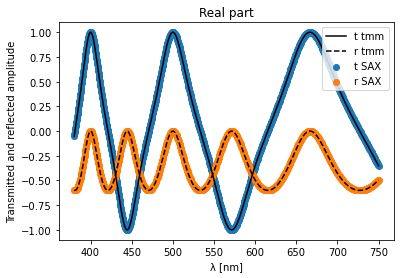

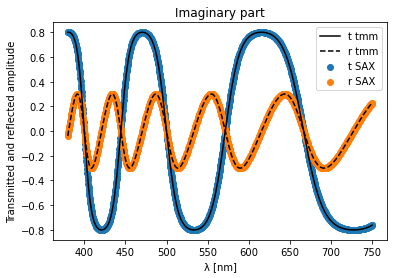

In [12]:
plt.scatter(wls, jnp.real(transmitted), label='t SAX')
plt.plot(wls, jnp.real(jnp.array(tnorm)), 'k', label='t tmm')
plt.scatter(wls, jnp.real(reflected), label='r SAX')
plt.plot(wls, jnp.real(jnp.array(rnorm)), 'k--', label='r tmm')
plt.xlabel("λ [nm]")
plt.ylabel("Transmitted and reflected amplitude")
plt.legend(loc="upper right")
plt.title("Real part")
plt.show()

plt.scatter(wls, jnp.imag(transmitted), label='t SAX')
plt.plot(wls, jnp.imag(jnp.array(tnorm)), 'k', label='t tmm')
plt.scatter(wls, jnp.imag(reflected), label='r SAX')
plt.plot(wls, jnp.imag(jnp.array(rnorm)), 'k--', label='r tmm')
plt.xlabel("λ [nm]")
plt.ylabel("Transmitted and reflected amplitude")
plt.legend(loc="upper right")
plt.title("Imaginary part")
plt.show()

## Notch filter

Again with only two alternating materials, let's do a notch filter in reflection that reflects for a narrow range of wavelengths around $\lambda_0$, and nowhere else. An intuitive starting point is the stack [1,2]

$$ n_i | \left[ (2-p)ApB\right]^N | n_f $$

with $n_i$ and $n_f$ boundary indices, A and B the respective quarter wave plates at $\lambda_0$

$$ A \rightarrow d=\frac{1}{4}\frac{\lambda_0}{n_A} \text{ of } n_A$$
$$ B \rightarrow d=\frac{1}{4}\frac{\lambda_0}{n_B}  \text{ of } n_B $$

and $p$ is small. From the analytical expressions of [2], we consider materials $n_A = 2.35$, and $n_B = 1.45$, and target $\lambda_0 = 532$ nm. To obtain adequate performance, we use the starting point $p = 0.12$ and $N = 140$. 

[1] https://www.optilayer.com/notch-filters

[2] T.V. Amotchkina, "Analytical estimations for the reference wavelength reflectance and width of high reflection zone of two-material periodic multilayers," Appl. Opt. 52, 4590-4595 (2013).

Let's see how a single such layer surrounded by air performs :

In [13]:
nA = 2.35
nB = 1.45
p = 0.12
wl0 = 532.
ni = 1.
nf = 1.

dA = (2 - p)*wl0/4/nA
dB = p*wl0/4/nB

In [14]:
repeated_unit_BCs = sax.circuit(
    models = {
        "air-A": interface_ij,
        "A": propagation_i,
        "AB": interface_ij,
        "B": propagation_i,
        "B-air": interface_ij,
    },
    connections={
        "air-A:out": "A:in",
        "A:out": "AB:in",
        "AB:out": "B:in",
        "B:out": "B-air:in",
    },
    ports={
        "air-A:in": "in",
        "B-air:out": "out",
    },
)

params = repeated_unit_BCs["default_params"]
params = sax.copy_params(params)

params['A']['ni'] = nA
params['A']['di'] = dA
params['B']['ni'] = nB
params['B']['di'] = dB
params['AB']['ni'] = nA
params['AB']['nj'] = nB
params['air-A']['ni'] = 1.
params['air-A']['nj'] = nA
params['B-air']['ni'] = nB
params['B-air']['nj'] = 1.

print(params)

{'air-A': {'ni': 1.0, 'nj': 2.35, 'wl': 532.0}, 'A': {'ni': 2.35, 'di': 106.39999999999999, 'wl': 532.0}, 'B-air': {'ni': 1.45, 'nj': 1.0, 'wl': 532.0}, 'AB': {'ni': 2.35, 'nj': 1.45, 'wl': 532.0}, 'B': {'ni': 1.45, 'di': 11.006896551724138, 'wl': 532.0}}


In [15]:
params = sax.set_global_params(params, wl=wls)

repeated_unit_BCs_transmitted = repeated_unit_BCs["in","out"]
transmitted = repeated_unit_BCs_transmitted(params)

repeated_unit_BCs_reflected = repeated_unit_BCs["in","in"]
reflected = repeated_unit_BCs_reflected(params)

In [16]:
# tmm syntax (https://github.com/sbyrnes321/tmm)
d_list = [jnp.inf,dA,dB,jnp.inf]
n_list = [1.,nA,nB,1.]
# initialize lists of y-values to plot
rnorm=[]
tnorm = []
for l in wls:
    rnorm.append(coh_tmm('s',n_list, d_list, 0, l)['r'])
    tnorm.append(coh_tmm('s',n_list, d_list, 0, l)['t'])

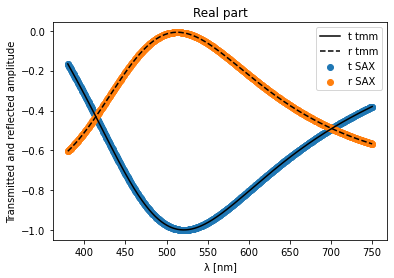

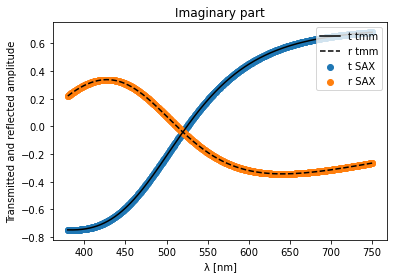

In [17]:
plt.scatter(wls, jnp.real(transmitted), label='t SAX')
plt.plot(wls, jnp.real(jnp.array(tnorm)), 'k', label='t tmm')
plt.scatter(wls, jnp.real(reflected), label='r SAX')
plt.plot(wls, jnp.real(jnp.array(rnorm)), 'k--', label='r tmm')
plt.xlabel("λ [nm]")
plt.ylabel("Transmitted and reflected amplitude")
plt.legend(loc="upper right")
plt.title("Real part")
plt.show()

plt.scatter(wls, jnp.imag(transmitted), label='t SAX')
plt.plot(wls, jnp.imag(jnp.array(tnorm)), 'k', label='t tmm')
plt.scatter(wls, jnp.imag(reflected), label='r SAX')
plt.plot(wls, jnp.imag(jnp.array(rnorm)), 'k--', label='r tmm')
plt.xlabel("λ [nm]")
plt.ylabel("Transmitted and reflected amplitude")
plt.legend(loc="upper right")
plt.title("Imaginary part")
plt.show()

A single layer does not look notch-like, but the SAX approach does replicate the calculation from the other solver. Repeating the middle part $N$ times to define the full notch filter :

In [76]:
def notch_filter(N=1):
    
    models_dict = {}
    connections_dict = {}
    
    models_dict["air-0_A"] = interface_ij
    connections_dict["air-0_A:out"] = "0_A:in"
    
    # First N-1 layers
    for i in range(N):
        models_dict[f"{i}_A"] = propagation_i
        models_dict[f"{i}_A-B"] = interface_ij
        models_dict[f"{i}_B"] = propagation_i
        models_dict[f"{i}_B-A"] = interface_ij
        
        connections_dict[f"{i}_A:out"] = f"{i}_A-B:in"
        connections_dict[f"{i}_A-B:out"] = f"{i}_B:in"
        connections_dict[f"{i}_B:out"] = f"{i}_B-A:in"
        connections_dict[f"{i}_B-A:out"] = f"{i+1}_A:in"

    # Last layer (no BA interface)
    models_dict[f"{N}_A"] = propagation_i
    models_dict[f"{N}_A-B"] = interface_ij
    models_dict[f"{N}_B"] = propagation_i
    models_dict[f"{N}_B-air"] = interface_ij
    
    connections_dict[f"{N}_A:out"] = f"{N}_A-B:in"
    connections_dict[f"{N}_A-B:out"] = f"{N}_B:in"
    connections_dict[f"{N}_B:out"] = f"{N}_B-air:in"

    stack = sax.circuit(
        models = models_dict,
        connections = connections_dict,
        ports = {
            "air-0_A:in": "in",
            f"{N}_B-air:out": "out",
        },
    )
    
    return stack

In [77]:
N = 1

stack = notch_filter(N)
print(stack)
params = sax.copy_params(stack["default_params"])

{'default_params': {'1_B-air': {'ni': 1.0, 'nj': 1.0, 'wl': 532.0}, '1_A-B': {'ni': 1.0, 'nj': 1.0, 'wl': 532.0}, '1_B': {'ni': 1.0, 'di': 1000.0, 'wl': 532.0}, 'air-0_A': {'ni': 1.0, 'nj': 1.0, 'wl': 532.0}, '0_A': {'ni': 1.0, 'di': 1000.0, 'wl': 532.0}, '0_B-A': {'ni': 1.0, 'nj': 1.0, 'wl': 532.0}, '1_A': {'ni': 1.0, 'di': 1000.0, 'wl': 532.0}, '0_A-B': {'ni': 1.0, 'nj': 1.0, 'wl': 532.0}, '0_B': {'ni': 1.0, 'di': 1000.0, 'wl': 532.0}}, ('out', 'out'): <function _model_ijkl at 0x7f110061b950>, ('out', 'in'): <function _model_ijkl at 0x7f110061b950>, ('in', 'out'): <function _model_ijkl at 0x7f110061b950>, ('in', 'in'): <function _model_ijkl at 0x7f110061b950>}


The non-global parameters are still at their arbitrary default values, so let's initialize :

In [78]:
params['air-0_A']['ni'] = ni
params['air-0_A']['nj'] = nA

for i in range(N):
    params[f"{i}_A"]['ni'] = nA
    params[f"{i}_A"]['di'] = dA
    params[f"{i}_A-B"]['ni'] = nA
    params[f"{i}_A-B"]['nj'] = nB
    params[f"{i}_B"]['ni'] = nB
    params[f"{i}_B"]['di'] = dB
    params[f"{i}_B-A"]['ni'] = nB
    params[f"{i}_B-A"]['nj'] = nA
    
params[f"{N}_A"]['ni'] = nA
params[f"{N}_A"]['di'] = dA
params[f"{N}_A-B"]['ni'] = nA
params[f"{N}_A-B"]['nj'] = nB
params[f"{N}_B"]['ni'] = nB
params[f"{N}_B"]['di'] = dB
params[f'{N}_B-air']['ni'] = nB
params[f'{N}_B-air']['nj'] = nf

print(params)

{'1_B-air': {'ni': 1.45, 'nj': 1.0, 'wl': 532.0}, '1_A-B': {'ni': 2.35, 'nj': 1.45, 'wl': 532.0}, '1_B': {'ni': 1.45, 'di': 11.006896551724138, 'wl': 532.0}, 'air-0_A': {'ni': 1.0, 'nj': 2.35, 'wl': 532.0}, '0_A': {'ni': 2.35, 'di': 106.39999999999999, 'wl': 532.0}, '0_B-A': {'ni': 1.45, 'nj': 2.35, 'wl': 532.0}, '1_A': {'ni': 2.35, 'di': 106.39999999999999, 'wl': 532.0}, '0_A-B': {'ni': 2.35, 'nj': 1.45, 'wl': 532.0}, '0_B': {'ni': 1.45, 'di': 11.006896551724138, 'wl': 532.0}}


We can now proceed to simulation :

In [79]:
params = sax.set_global_params(params, wl=wls)

stack_transmitted = stack["in","out"]
%time transmitted = stack_transmitted(params)

stack_reflected = stack["in","in"]
%time reflected = stack_reflected(params)

CPU times: user 87.7 ms, sys: 8.08 ms, total: 95.8 ms
Wall time: 72 ms
CPU times: user 118 ms, sys: 7.93 ms, total: 126 ms
Wall time: 98.2 ms


Again compare :

In [80]:
d_list = []
n_list = []

d_list.append(jnp.inf)
n_list.append(1.)

for i in range(N+1): # From way N defined in stack circuit
    d_list.append(dA)
    n_list.append(nA)
    d_list.append(dB)
    n_list.append(nB)

d_list.append(jnp.inf)
n_list.append(1.)

print(d_list)
print(n_list)

rnorm=[]
tnorm = []
for l in wls:
    rnorm.append(coh_tmm('s',n_list, d_list, 0, l)['r'])
    tnorm.append(coh_tmm('s',n_list, d_list, 0, l)['t'])

[inf, 106.39999999999999, 11.006896551724138, 106.39999999999999, 11.006896551724138, inf]
[1.0, 2.35, 1.45, 2.35, 1.45, 1.0]


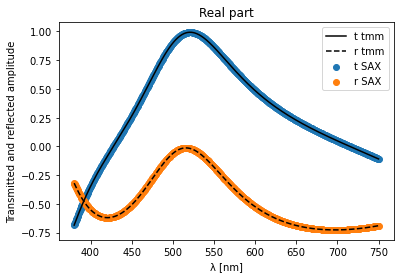

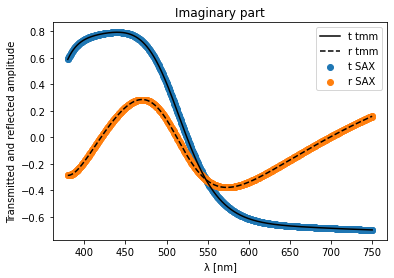

In [81]:
plt.scatter(wls, jnp.real(transmitted), label='t SAX')
plt.plot(wls, jnp.real(jnp.array(tnorm)), 'k', label='t tmm')
plt.scatter(wls, jnp.real(reflected), label='r SAX')
plt.plot(wls, jnp.real(jnp.array(rnorm)), 'k--', label='r tmm')
plt.xlabel("λ [nm]")
plt.ylabel("Transmitted and reflected amplitude")
plt.legend(loc="upper right")
plt.title("Real part")
plt.show()

plt.scatter(wls, jnp.imag(transmitted), label='t SAX')
plt.plot(wls, jnp.imag(jnp.array(tnorm)), 'k', label='t tmm')
plt.scatter(wls, jnp.imag(reflected), label='r SAX')
plt.plot(wls, jnp.imag(jnp.array(rnorm)), 'k--', label='r tmm')
plt.xlabel("λ [nm]")
plt.ylabel("Transmitted and reflected amplitude")
plt.legend(loc="upper right")
plt.title("Imaginary part")
plt.show()

It is consistent for $N=1$. Adding more layers :

In [136]:
N = 20

stack = notch_filter(N)
params = sax.copy_params(stack["default_params"])

In [137]:
params['air-0_A']['ni'] = ni
params['air-0_A']['nj'] = nA

for i in range(N):
    params[f"{i}_A"]['ni'] = nA
    params[f"{i}_A"]['di'] = dA
    params[f"{i}_A-B"]['ni'] = nA
    params[f"{i}_A-B"]['nj'] = nB
    params[f"{i}_B"]['ni'] = nB
    params[f"{i}_B"]['di'] = dB
    params[f"{i}_B-A"]['ni'] = nB
    params[f"{i}_B-A"]['nj'] = nA
    
params[f"{N}_A"]['ni'] = nA
params[f"{N}_A"]['di'] = dA
params[f"{N}_A-B"]['ni'] = nA
params[f"{N}_A-B"]['nj'] = nB
params[f"{N}_B"]['ni'] = nB
params[f"{N}_B"]['di'] = dB
params[f'{N}_B-air']['ni'] = nB
params[f'{N}_B-air']['nj'] = nf

In [138]:
params = sax.set_global_params(params, wl=wls)

stack_reflected = stack["in","in"]
%time reflected = stack_reflected(params)

CPU times: user 8.21 s, sys: 727 ms, total: 8.94 s
Wall time: 7.2 s


Again compare :

In [139]:
d_list = []
n_list = []

d_list.append(jnp.inf)
n_list.append(1.)

for i in range(N+1): # From way N defined in stack circuit
    d_list.append(dA)
    n_list.append(nA)
    d_list.append(dB)
    n_list.append(nB)

d_list.append(jnp.inf)
n_list.append(1.)

Rnorm=[]
for l in wls:
    Rnorm.append(coh_tmm('s',n_list, d_list, 0, l)['R'])

Looking at reflected intensity this time :

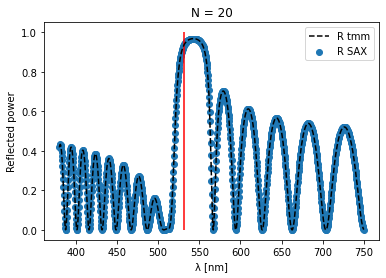

In [140]:
plt.scatter(wls, jnp.abs(reflected)**2, label='R SAX')
plt.plot(wls, Rnorm, 'k--', label='R tmm')
plt.vlines(wl0, ymin=0, ymax=1, color='r')
plt.xlabel("λ [nm]")
plt.ylabel("Reflected power")
plt.legend(loc="upper right")
plt.title("N = {}".format(N))
plt.show()

Now we start to see notch behaviour. The reflection can be brought closer vertically to $1$ and closer to the desired wavelength $532$ nm (vertical line) by increasing the number of layers even more. The ripples, however, must be optimized away by tuning the widths of the layers from this starting point. We can use the SAX autograd to do this, and speed up the optimization by JIT-ing the function.

We will create a stack with a large number of layers, and compile it

In [141]:
N = 100

stack = notch_filter(N)
params = sax.copy_params(stack["default_params"])

params['air-0_A']['ni'] = ni
params['air-0_A']['nj'] = nA

for i in range(N):
    params[f"{i}_A"]['ni'] = nA
    params[f"{i}_A"]['di'] = dA
    params[f"{i}_A-B"]['ni'] = nA
    params[f"{i}_A-B"]['nj'] = nB
    params[f"{i}_B"]['ni'] = nB
    params[f"{i}_B"]['di'] = dB
    params[f"{i}_B-A"]['ni'] = nB
    params[f"{i}_B-A"]['nj'] = nA
    
params[f"{N}_A"]['ni'] = nA
params[f"{N}_A"]['di'] = dA
params[f"{N}_A-B"]['ni'] = nA
params[f"{N}_A-B"]['nj'] = nB
params[f"{N}_B"]['ni'] = nB
params[f"{N}_B"]['di'] = dB
params[f'{N}_B-air']['ni'] = nB
params[f'{N}_B-air']['nj'] = nf

params = sax.set_global_params(params, wl=wls)

In [142]:
stack_r_jit = jax.jit(stack["in", "in"])

In [ ]:
%time reflected = stack_r_jit(params)

The JIT-ing was very slow, but now we are even faster than the other solver :

In [100]:
%time reflected = stack_r_jit(params)

CPU times: user 17.3 ms, sys: 4.98 ms, total: 22.3 ms
Wall time: 11.2 ms


In [113]:
print(params.items())

dict_items([('9_B-A', {'ni': 1.45, 'nj': 2.35, 'wl': DeviceArray([380.     , 380.3704 , 380.74072, 381.1111 , 381.48148,
             381.85187, 382.22223, 382.5926 , 382.96298, 383.3333 ,
             383.7037 , 384.0741 , 384.44443, 384.81482, 385.18518,
             385.55557, 385.92593, 386.2963 , 386.6667 , 387.03702,
             387.4074 , 387.7778 , 388.14813, 388.51852, 388.8889 ,
             389.25928, 389.62964, 390.     , 390.3704 , 390.74072,
             391.1111 , 391.4815 , 391.85184, 392.22223, 392.5926 ,
             392.96298, 393.33334, 393.7037 , 394.0741 , 394.44443,
             394.81482, 395.1852 , 395.55557, 395.92593, 396.2963 ,
             396.6667 , 397.03705, 397.4074 , 397.7778 , 398.14813,
             398.51852, 398.88892, 399.25928, 399.62964, 400.     ,
             400.37036, 400.74075, 401.11108, 401.48148, 401.85184,
             402.2222 , 402.5926 , 402.96295, 403.33334, 403.70367,
             404.07407, 404.44446, 404.8148 , 405.18518, 405.55

Optimizing in terms of all the layer thicknesses :

In [ ]:
@jax.jit
def loss(ddAs, ddBs):
    params = sax.set_global_params(mzi["default_params"], wl=1.55e-6)
    # We isolate the propagation layers
    variables = []
    for ddA_index in range(len(ddAs)):
        params[]
    for model in params.items():
        
        if model[0][-2:] == 
    params["top"]["length"] = 1.5e-6 + delta_length
    params["btm"]["length"] = 1.5e-6
    detected = mzi["in1", "out1"](params)
    return (abs(detected)**2).mean()